# Image Areafilter / De-Areafilter Demo

This notebook demonstrates how to area filter (box filter) original image and then attempt to reconstruct the original image.

## 1. Load Original Image

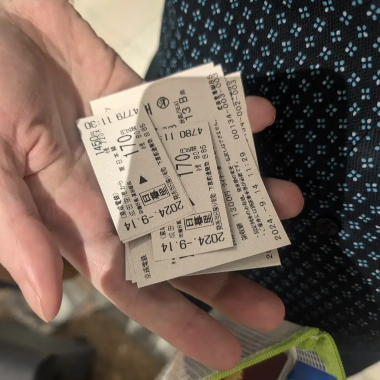

In [4]:
import PIL.Image as Image
import torchvision.transforms.functional as TF

original = TF.to_tensor(Image.open('template.png').convert('RGBA')).unsqueeze_(0)

H, W = original.size()[-2:]

TF.to_pil_image(original[0])

## 2. Filter the Image

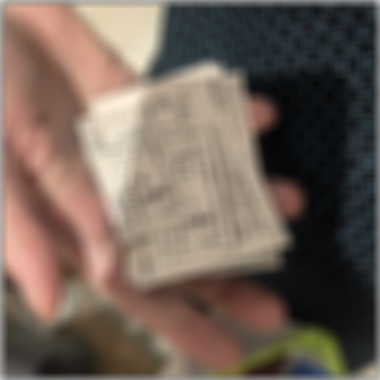

In [9]:
import torch
import torch.nn.functional as F

CHUNK_SIZE = 16

filtered = F.avg_pool2d(F.pad(original, (CHUNK_SIZE, CHUNK_SIZE, CHUNK_SIZE, CHUNK_SIZE)), CHUNK_SIZE, 1)[..., CHUNK_SIZE//2:, CHUNK_SIZE//2:][...,:H, :W]

TF.to_pil_image(filtered[0])

## 3. Restore the Original Image with Gradient-Decent

just gradient descent the `trained` (`filtered` as basis) to output `filtered` after a a `avg_pool2d` (~ `area` filter).

(could use deconvolution .. to calculate the output faster, since we know the PSF)

use device xpu
0.00% loss 0.015954038128256798
5.00% loss 0.005106301978230476
10.00% loss 0.0022920246701687574
15.00% loss 0.001034096465446055
20.00% loss 0.0004450158157851547
25.00% loss 0.0002127866609953344
30.00% loss 0.00015659671043977141
35.00% loss 0.00012710498413071036
40.00% loss 0.00010931160795735195
45.00% loss 9.756359941093251e-05
50.00% loss 8.882571273716167e-05
55.00% loss 8.261179027613252e-05
60.00% loss 7.673893560422584e-05
65.00% loss 7.207618182292208e-05
70.00% loss 6.929350638529286e-05
75.00% loss 6.771017069695517e-05
80.00% loss 6.550880789291114e-05
85.00% loss 6.28755587968044e-05
90.00% loss 6.108654633862898e-05
95.00% loss 5.885068094357848e-05


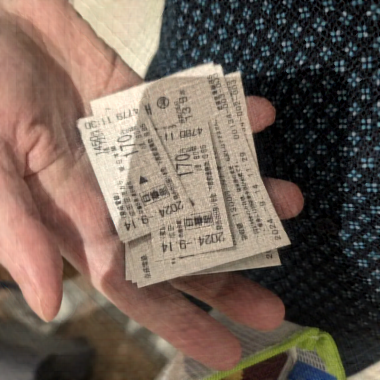

In [11]:
import torch.nn as nn
import torch.optim as optim

device = 'cpu'
if torch.xpu.is_available():
    device = 'xpu'
elif torch.cuda.is_available():
    device = 'cuda'
print('use device', device)

trained = nn.Parameter(filtered.clone(), requires_grad=True)

optimizer = optim.Adam([trained])
ROUNDS = 2000
for i in range(ROUNDS):
    #frame_trained.data.add_(torch.randn_like(frame_trained).mul_(1/1024))
    optimizer.zero_grad()
    loss = F.l1_loss(
        F.avg_pool2d(F.pad(trained, (CHUNK_SIZE, CHUNK_SIZE, CHUNK_SIZE, CHUNK_SIZE)), CHUNK_SIZE, 1)[..., CHUNK_SIZE//2:, CHUNK_SIZE//2:][...,:H, :W],
        filtered
    )
    loss.backward()
    optimizer.step()
    trained.data.clamp_(0, 1)
    if (i % 100) == 0:
        print(f'{i / ROUNDS * 100:03.2f}%', 'loss', float(loss))

TF.to_pil_image(trained[0])